In [354]:
import pandas as pd
import numpy as np
import os
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

# CODE TO DETERMINE THE GENDER OF THE SPEAKER

In [355]:
df = pd.read_csv("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/balanced-all.csv")
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


In [356]:
n_samples = len(df)
# get total male samples
n_male_samples = len(df[df['gender'] == 'male'])
# get total female samples
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


In [357]:
label2int = {
    "male": 1,
    "female": 0
}

LOADING THE DATA IN .npy format

In [358]:
def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results"):
        os.mkdir("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/features.npy") and os.path.isfile("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/labels.npy"):
        X = np.load("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/features.npy")
        y = np.load("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/balanced-all.csv")
    # get total samples
    n_samples = len(df)
    # get total male samples
    n_male_samples = len(df[df['gender'] == 'male'])
    # get total female samples
    n_female_samples = len(df[df['gender'] == 'female'])
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/features", X)
    np.save("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/labels", y)
    return X, y

MODEL TRAINING STARTS HERE 

In [359]:
def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [360]:
# load the dataset
X, y = load_data()
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

In [361]:
def create_model(vector_length=128):
    """5 hidden dense layers from 256 units to 64, not the best model."""
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [362]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)              

In [363]:

tensorboard = TensorBoard(log_dir="logs")

early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 10

model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/10
848/848 [==============================] - 2s 2ms/step - loss: 0.5590 - accuracy: 0.7614 - val_loss: 0.3937 - val_accuracy: 0.8491
Epoch 2/10
848/848 [==============================] - 2s 2ms/step - loss: 0.4158 - accuracy: 0.8347 - val_loss: 0.3497 - val_accuracy: 0.8496
Epoch 3/10
848/848 [==============================] - 1s 2ms/step - loss: 0.3820 - accuracy: 0.8515 - val_loss: 0.3282 - val_accuracy: 0.8697
Epoch 4/10
848/848 [==============================] - 2s 2ms/step - loss: 0.3599 - accuracy: 0.8603 - val_loss: 0.3235 - val_accuracy: 0.8682
Epoch 5/10
848/848 [==============================] - 2s 2ms/step - loss: 0.3472 - accuracy: 0.8663 - val_loss: 0.2934 - val_accuracy: 0.8818
Epoch 6/10
848/848 [==============================] - 2s 2ms/step - loss: 0.3325 - accuracy: 0.8735 - val_loss: 0.2949 - val_accuracy: 0.8788
Epoch 7/10
848/848 [==============================] - 2s 2ms/step - loss: 0.3318 - accuracy: 0.8739 - val_loss: 0.2748 - val_accuracy: 0.8953
Epoch 

In [364]:
# save the model to a file
model.save("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/model.h5")

In [365]:
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.2673
Accuracy: 90.39%


In [366]:
import tsfresh

In [367]:
from tsfresh import extract_features
#from FeaturesExtractor import FeaturesExtractor

In [368]:
import argparse
parser = argparse.ArgumentParser(description="""Gender recognition script, this will load the model you trained, 
                                    and perform inference on a sample you provide (either using your voice or a file)""")
parser.add_argument("-f", "--file", help="The path to the file, preferred to be in WAV format")
args = parser.parse_args()
file = args.file
# construct the modegit clone https://github.com/librosa/librosa.git
#pip install -e librosal
model = create_model()
# load the saved/trained weights
model.load_weights("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/results/model.h5")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [369]:
import librosa

In [370]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
        result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [371]:
import librosa

In [372]:
import argparse
import librosa
from surfboard.feature_extraction import extract_features

WE USE THE WAV FILE TO TEST

In [373]:

file = "/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/test-samples/19-227-0005.wav"


In [374]:
features = extract_feature(file, mel=True, mfcc=True).reshape(1,-1)


In [375]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
848/848 [==============================] - 2s 2ms/step - loss: 0.3076 - accuracy: 0.8866 - val_loss: 0.2593 - val_accuracy: 0.9029
Epoch 2/100
848/848 [==============================] - 1s 2ms/step - loss: 0.2961 - accuracy: 0.8891 - val_loss: 0.2598 - val_accuracy: 0.8983
Epoch 3/100
848/848 [==============================] - 2s 2ms/step - loss: 0.2983 - accuracy: 0.8882 - val_loss: 0.2738 - val_accuracy: 0.8969
Epoch 4/100
848/848 [==============================] - 1s 2ms/step - loss: 0.2959 - accuracy: 0.8887 - val_loss: 0.2536 - val_accuracy: 0.9014
Epoch 5/100
848/848 [==============================] - 1s 2ms/step - loss: 0.2867 - accuracy: 0.8932 - val_loss: 0.2437 - val_accuracy: 0.9062
Epoch 6/100
848/848 [==============================] - 1s 2ms/step - loss: 0.2847 - accuracy: 0.8930 - val_loss: 0.2478 - val_accuracy: 0.9039
Epoch 7/100
848/848 [==============================] - 1s 2ms/step - loss: 0.2825 - accuracy: 0.8938 - val_loss: 0.2467 - val_accuracy: 0.9051

MALE AND FEMALE PROBABILITIES ARE CALCULATED

In [376]:
# predict the gender!
male_prob = model.predict(data["X_train"])[0][0]
female_prob = 1 - male_prob


In [377]:
male_prob.tolist()

0.9570325613021851

In [378]:
female_prob.tolist()

0.04296743869781494

In [380]:
if (male_prob > female_prob):
    gender = "male"
else:
    gender = "female"
print("Result:", gender)

Result: male


In [382]:
male_prob = np.array(male_prob)

In [383]:
female_prob = np.array(female_prob)

In [384]:
print(f"Probabilities::: Male: {male_prob*100:.2f}%    Female: {female_prob*100:.2f}%")

Probabilities::: Male: 95.70%    Female: 4.30%


# Age Recognition

# AUDIO DURATION

In [45]:
import wave
import contextlib
fname = '/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/test-samples/16-122828-0002.wav'
with contextlib.closing(wave.open(fname,'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    duration = frames / float(rate)
    print(duration)

2.9


In [385]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import seaborn
seaborn.set(style='ticks')

from IPython.display import Audio

import numpy as np
import scipy

import mir_eval
import librosa

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [386]:
# y, sr = librosa.load("/home/priscilla/Downloads/gender-recognition-by-voice-master/gender-recognition-by-voice-master/test-samples/16-122828-0002.wav", sr=22050)
# spectrogram = np.abs(librosa.stft(y))
# melspec = librosa.feature.melspectrogram(y=y, sr=sr)
# stft = np.abs(librosa.stft(y))
# mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
# mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
# contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
# tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
# chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
# features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
# features = features.reshape(1, -1)

# AGE RECOGNITION

In [397]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 



In [396]:
import sklearn 
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("/home/priscilla/Downloads/cv-valid-train.csv/cv-valid-train.csv") 
df[df['age'].notna()].head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
5,sample-000005.wav,a shepherd may like to travel but he should ne...,1,0,twenties,female,us,NaN
8,sample-000008.wav,put jackie right on the staff,3,0,seventies,male,us,NaN
13,sample-000013.wav,but he had found a guide and didn't want to mi...,1,0,thirties,female,us,NaN
14,sample-000014.wav,as they began to decorate the hallway a silhou...,1,0,sixties,male,england,NaN
19,sample-000019.wav,then they got ahold of some dough and went goofy,1,0,fifties,male,australia,NaN


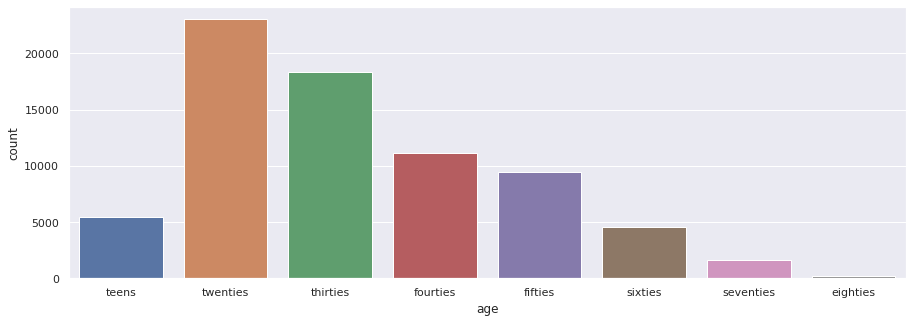

In [316]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age", 
        data=df[df['age'].notna()], 
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

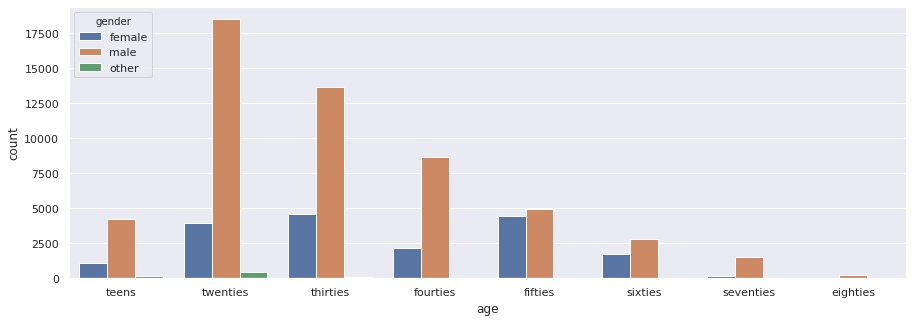

In [317]:
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

In [320]:
df = df[['filename','age','gender']]
#To clean the data we remove the sample with NaN attribute values.
data = df[df['age'].notna() & df['gender'].notna()]
data.reset_index(inplace=True, drop=True)
data.head()

,filename,age,gender
0,sample-000005.wav,twenties,female
1,sample-000008.wav,seventies,male
2,sample-000013.wav,thirties,female
3,sample-000014.wav,sixties,male
4,sample-000019.wav,fifties,male


In [321]:
cleanup_nums = {"gender": {"male":1,"female":0,"other":0.5}}
data = data.replace(cleanup_nums)
data.head()

,filename,age,gender
0,sample-000005.wav,twenties,0.0
1,sample-000008.wav,seventies,1.0
2,sample-000013.wav,thirties,0.0
3,sample-000014.wav,sixties,1.0
4,sample-000019.wav,fifties,1.0


In [322]:
import librosa

In [323]:
data

,filename,age,gender
0,sample-000005.wav,twenties,0.0
1,sample-000008.wav,seventies,1.0
2,sample-000013.wav,thirties,0.0
3,sample-000014.wav,sixties,1.0
4,sample-000019.wav,fifties,1.0
...,...,...,...
73461,sample-195766.wav,fourties,1.0
73462,sample-195767.wav,thirties,0.0
73463,sample-195770.wav,twenties,1.0
73464,sample-195771.wav,thirties,1.0


In [324]:
#get_feature_vector(data.iloc[0]['filename'],mfcc = True, chroma = True, mel = True)

In [325]:
from pydub import AudioSegment
# sound = AudioSegment.from_mp3("/home/priscilla/Downloads/cv-valid-train/*.mp3")
path = '/home/priscilla/Downloads/cv-valid-train/'

# used to convert mp3 to wav

In [327]:
# import os
# from pydub import AudioSegment

# path = "/home/priscilla/Downloads/cv-valid-train/"

# #Change working directory
# os.chdir(path)

# audio_files = os.listdir()

# # You dont need the number of files in the folder, just iterate over them directly using:
# for file in audio_files:
#     #spliting the file into the name and the extension
#     name, ext = os.path.splitext(file)
#     if ext == ".mp3":
#        mp3_sound = AudioSegment.from_mp3(file)
#        #rename them using the old name + ".wav"
#        mp3_sound.export("{0}.wav".format(name), format="wav")

In [328]:
ds_path = "/home/priscilla/Downloads/cv-valid-train/"

#this function is used to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features
features = extract_feature(data.iloc[0]['filename'], mfcc = True, chroma = True, mel = True)
print("features: ", features)

features:  [-6.25218140e+02  1.11320923e+02  6.32699394e+00  3.47576141e+01
  3.16199017e+01 -4.71464539e+00 -4.86030757e-01 -4.93402433e+00
 -1.27147331e+01 -2.05514836e+00 -3.74111772e+00 -1.07029629e+01
 -1.12026367e+01 -1.20035229e+01 -8.48957920e+00 -5.46327591e+00
 -4.95421696e+00 -3.71519804e+00 -6.33052874e+00 -6.33847332e+00
 -1.44802153e+00 -2.42254114e+00 -7.06434727e+00 -7.54642153e+00
 -4.18499899e+00 -2.18948078e+00 -6.81115770e+00 -9.23299694e+00
 -3.42529178e+00 -3.59966421e+00 -8.47987843e+00 -4.89713526e+00
 -1.45711184e+00 -4.38532877e+00 -5.10601950e+00 -2.65830350e+00
 -1.74536824e+00 -2.29873490e+00 -1.64131987e+00 -6.08225949e-02
  5.17807066e-01  5.02760768e-01  5.08159578e-01  5.41249216e-01
  6.11341894e-01  6.54330671e-01  7.36001432e-01  7.34930813e-01
  7.02107430e-01  6.49511695e-01  6.21229351e-01  5.57735324e-01
  2.01864837e-04  1.45452650e-04  4.07070824e-04  6.32127188e-03
  1.77117348e-01  8.15398991e-01  4.58821625e-01  1.07299037e-01
  2.91391294e-

In [329]:
#the function create dataframe to store the feature and label related to each other
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig)-1
    stop_counter = 55001
    
    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "label"])

df_features = create_df_features(data)
df_features.head()

55000/73465

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.0,2679.939570,3347.669489,5745.486746,-625.218140,111.320923,6.326994,34.757614,31.619902,-4.714645,...,-10.702963,-11.202637,-12.003523,-8.489579,-5.463276,-4.954217,-3.715198,-6.330529,-6.338473,twenties
1,1.0,2859.467798,2576.661658,4912.241181,-469.897675,126.299873,-16.546749,3.553606,2.178286,13.770478,...,-10.987110,1.146530,6.103549,-1.724738,-1.226475,-6.429199,-7.261916,-4.788060,-3.121077,seventies
2,0.0,1976.049163,1830.611037,3344.301008,-418.205048,147.668320,-49.972744,-2.285532,37.187012,-8.904264,...,-13.845863,-9.927491,-7.871619,-5.473860,-2.295655,-6.554991,-5.206914,-0.407431,-3.882371,thirties
3,1.0,2333.782018,2533.276030,4398.731436,-464.911224,118.436134,19.749296,27.143938,26.439018,2.309576,...,-5.458494,-2.907650,-4.495940,-2.715731,-0.079106,-5.292979,-5.866175,0.601412,-3.376775,sixties
4,1.0,2351.958974,2974.758775,4743.172457,-343.828766,157.151764,7.660183,41.900478,-15.153757,28.925409,...,0.101646,6.319596,-1.603062,3.837600,-2.643968,2.324787,-1.382977,3.790324,-3.534814,fifties


In [331]:
from sklearn.preprocessing import StandardScaler

def scale_features(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(data.iloc[:, 0:-1], dtype = float))
    # with data.iloc[:, 0:-1] we don't consider the label column
        
    return scaled_data, scaler

x, scaler = scale_features(df_features)

In [332]:
print("Before scaling:", df_features.iloc[0].values[:-1])
print("\nAfter scaling:", x[0])

Before scaling: [0.0 2679.939569797983 3347.6694888838924 5745.486745886655
 -625.2181396484375 111.3209228515625 6.326993942260742 34.75761413574219
 31.619901657104492 -4.7146453857421875 -0.4860307574272156
 -4.934024333953857 -12.714733123779297 -2.0551483631134033
 -3.7411177158355713 -10.702962875366211 -11.20263671875
 -12.003522872924805 -8.489579200744629 -5.463275909423828
 -4.954216957092285 -3.715198040008545 -6.330528736114502
 -6.338473320007324]

After scaling: [-1.73152724 -0.25960186  0.71093387  0.16477031 -1.99980957 -0.21295858
  0.48681377  0.77058697  1.67546465 -0.87158697  0.1654742  -0.27995358
 -1.09142434  0.46285236 -0.01711303 -1.19047041 -1.70870143 -1.33381014
 -1.18695484 -0.56161472 -0.36905988 -0.50784709 -1.03844068 -0.64842001]


In [333]:
df_features['label'].unique()

array(['twenties', 'seventies', 'thirties', 'sixties', 'fifties',
       'fourties', 'teens', 'eighties'], dtype=object)

In [335]:
from sklearn.preprocessing import LabelEncoder

def get_labels(data):
    labels = data.iloc[:, -1]
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    return labels, encoder

y, encoder = get_labels(df_features)
classes = encoder.classes_
print("Before encoding:", df_features.iloc[0].values[-1])
print("\nAfter encoding:", y[0])
print("\nClasses:", classes)

Before encoding: twenties

After encoding: 7

Classes: ['eighties' 'fifties' 'fourties' 'seventies' 'sixties' 'teens' 'thirties'
 'twenties']


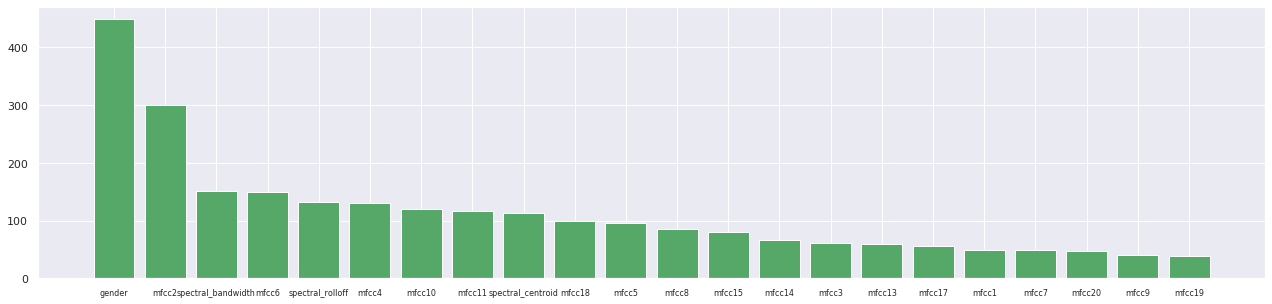

In [336]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

n_features = 22

f_selector = SelectKBest(f_classif, k=n_features).fit(x, y)
X_new = f_selector.transform(x)
scores = f_selector.scores_

indices = np.argsort(scores)[::-1]

features = []
for i in range(n_features):
    features.append(df_features.columns[indices[i]])
    
plt.figure(figsize=(22, 5))
plt.bar(features, scores[indices[range(n_features)]], color='g')
plt.xticks(fontsize=8)
plt.show()

In [337]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

classifiers_and_params = [
    (SVC(), {'C': [200, 150, 100], 'gamma': ['auto', 'scale']}),
    (RandomForestClassifier(), {'n_estimators': [100, 150, 200]})
]

for tup in classifiers_and_params:
    print("{}".format(tup[0].__class__.__name__))
    
    # the main CV process
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)
    fold_counter = 0

    results = list()
    for train_idx, test_idx in outer_cv.split(X_new):
        fold_counter += 1
        
        # split data in training and test sets
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # the CV process used for the Grid Search
        inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)

        # define and run the Grid Search CV process
        gs = GridSearchCV(tup[0], tup[1], scoring='f1_macro', cv=inner_cv, refit=True)
        res = gs.fit(X_train, y_train)

        # get the best model, re-fit on the whole training set
        best_model = res.best_estimator_

        # evaluation on the test set
        pred = best_model.predict(X_test)
        score = f1_score(y_test, pred, average='macro')
        results.append(score)
        
        print("\tFold {}, Best Params {} with F1 Score {:.3f}, F1 Score on Test data {:.3f}"
              .format(fold_counter, res.best_params_, res.best_score_, score))

    print('\tAverage F1 Score on Test Set: {:.3f}\n'.format(np.mean(results)))

SVC
	Fold 1, Best Params {'C': 100, 'gamma': 'scale'} with F1 Score 0.765, F1 Score on Test data 0.830
	Fold 2, Best Params {'C': 100, 'gamma': 'auto'} with F1 Score 0.764, F1 Score on Test data 0.830
	Fold 3, Best Params {'C': 100, 'gamma': 'auto'} with F1 Score 0.769, F1 Score on Test data 0.825
	Average F1 Score on Test Set: 0.828

RandomForestClassifier
	Fold 1, Best Params {'n_estimators': 200} with F1 Score 0.648, F1 Score on Test data 0.730
	Fold 2, Best Params {'n_estimators': 150} with F1 Score 0.635, F1 Score on Test data 0.713
	Fold 3, Best Params {'n_estimators': 150} with F1 Score 0.643, F1 Score on Test data 0.712
	Average F1 Score on Test Set: 0.718



In [338]:
import itertools
import matplotlib.pyplot as plt

def my_plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix (without normalization)"
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title(title)

    thresh = cm.max() / 2.
    fmt = "{:0.2f}" if normalize else "{:d}"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

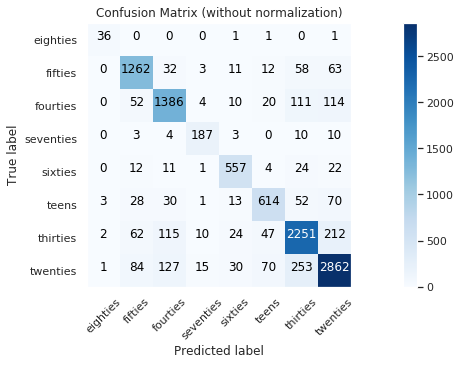

In [339]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

model = SVC(C=100, gamma='scale')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
my_plot_confusion_matrix(cm, classes=classes)

plt.grid(False)
plt.show()

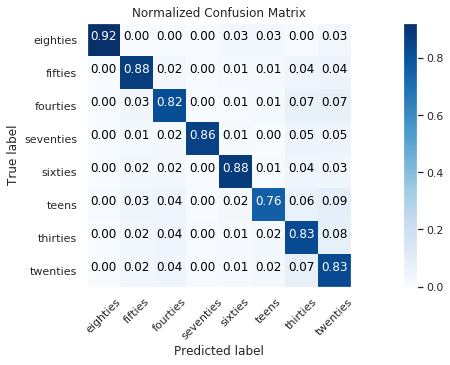

In [340]:
# Plot normalized confusion matrix
plt.figure()
my_plot_confusion_matrix(cm, classes=classes, normalize=True)

plt.grid(False)
plt.show()

In [ ]:
import joblib
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(model, filename)

In [334]:
##############################################################

In [137]:
from surfboard.feature_extraction import extract_features

In [155]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features